In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import netCDF4
from functions import *

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow import keras

from windrose import WindroseAxes
from windrose import WindAxes
import windrose
import matplotlib.cm as cm
import datetime

# Przygotowanie danych:

Zmiana z formatu CDF4 na DataFrame

In [2]:
# create training set (1994 - 2001, one gridpoint):
def create_trainset(to_csv=False):
    data = pd.DataFrame()
    years = range(1994, 2002)
    for year in years:
        filename = 'workdir/data_raw/ERA5_area/data_area_'+str(year)+'.nc'
        f = netCDF4.Dataset(filename)
        var_names = ['t2m', 'd2m', 'msl', 'tp', 'u10', 'v10', 'u100', 'v100', 'ssrd']
        # latitudes = f.variables['latitude'][:]
        # longitudes = f.variables['longitude'][:]
        times = netCDF4.num2date(f.variables['time'][:], f.variables['time'].units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
        times = [t.isoformat() for t in times]

        variables = {key: f.variables[key][:,4,4] for key in var_names}
        df = pd.DataFrame({**{
            'Date Time': times,
            **variables
        }})
        df['Date Time'] = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)
        df['tp'] = df['tp'].fillna(0)
        ssrd_new = df['ssrd']
        ssrd_new = ssrd_new.where(ssrd_new>10, 0) / 3600 / 1000 #unit from [J/m^2] to [kW/m^2]
        df['ssrd'] = ssrd_new
        df['windspeed_10'] = (df['u10']**2 + df['v10']**2)**(1/2)
        df['windspeed_100'] = (df['u100']**2 + df['v100']**2)**(1/2)
        df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

        data = data.append(df)

    if to_csv:
        data.to_csv('data/data_spacial/trainset_[50,20].csv', index = False)

    f.close()
    return data

train = create_trainset(to_csv=True)

Stworzenie testowych datasetów (dla każdego punktu siatki):

In [3]:
# Creating testsets (year 2002, all gridpoint):
def create_datasets(filename, to_csv=False):
    f = netCDF4.Dataset(filename)
    var_names = ['t2m', 'd2m', 'msl', 'tp', 'u10', 'v10', 'u100', 'v100', 'ssrd']
    latitudes = f.variables['latitude'][:]
    longitudes = f.variables['longitude'][:]
    times = netCDF4.num2date(f.variables['time'][:], f.variables['time'].units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
    times = [t.isoformat() for t in times]
    dataframes = []
    for i in range(len(latitudes)):
        row = []
        for j in range(len(longitudes)):
            variables = {key: f.variables[key][:,i,j] for key in var_names}
            df = pd.DataFrame({**{
                'Date Time': times,
                **variables
            }})
            df['Date Time'] = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)
            df['tp'] = df['tp'].fillna(0)
            ssrd_new = df['ssrd']
            ssrd_new = ssrd_new.where(ssrd_new>10, 0) / 3600 / 1000 #unit from [J/m^2] to [kW/m^2]
            df['ssrd'] = ssrd_new
            df['windspeed_10'] = (df['u10']**2 + df['v10']**2)**(1/2)
            df['windspeed_100'] = (df['u100']**2 + df['v100']**2)**(1/2)
            df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)
            row.append(df)
            if to_csv:
                df.to_csv('data/data_spacial/data_[{},{}].csv'.format(latitudes[i],longitudes[j]), index = False)
        dataframes.append(row)
    f.close()
    return dataframes

test_sets = create_datasets('workdir/data_raw/ERA5_area/data_area_2002.nc', to_csv=True)


In [4]:
test_sets[4][4].head()

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,266.380440,264.058589,102678.363977,0.000076,0.0,2002-01-01 00:00:00,6.263798,9.871162
1,266.168470,263.678457,102777.784631,0.000039,0.0,2002-01-01 01:00:00,6.185724,9.817204
2,265.287029,262.801167,102832.547484,0.000024,0.0,2002-01-01 02:00:00,6.041196,9.536901
3,265.521079,263.113755,102840.533733,0.000035,0.0,2002-01-01 03:00:00,5.805256,9.601193
4,265.930004,263.685525,102868.404113,0.000048,0.0,2002-01-01 04:00:00,5.926083,9.747236


In [5]:
train

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,276.591677,273.597511,100506.631227,1.948620e-06,0.0,1994-01-01 00:00:00,2.114012,5.362126
1,276.239812,273.369413,100396.295800,4.871549e-07,0.0,1994-01-01 01:00:00,2.405844,5.321953
2,276.160179,273.007498,100208.275227,8.673617e-19,0.0,1994-01-01 02:00:00,2.965654,6.456440
3,276.464820,273.139795,100168.467620,8.673617e-19,0.0,1994-01-01 03:00:00,2.014695,4.494271
4,276.756498,273.067564,100306.869420,1.428988e-05,0.0,1994-01-01 04:00:00,2.988498,6.387397
...,...,...,...,...,...,...,...,...
8755,268.717000,266.967436,102182.766620,3.642980e-04,0.0,2001-12-31 19:00:00,4.235353,7.019902
8756,268.546893,266.427170,102303.229532,2.378932e-04,0.0,2001-12-31 20:00:00,4.918296,7.977007
8757,268.176911,266.142592,102400.924228,2.040622e-04,0.0,2001-12-31 21:00:00,5.307329,8.410772
8758,267.034643,264.759426,102492.450642,1.640802e-04,0.0,2001-12-31 22:00:00,5.672169,9.402993


## Zamiana daty na sygnał

In [6]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

Text(0.5, 1.0, 'Time of day signal')

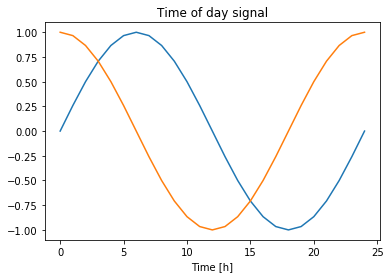

In [7]:
train = datetimeToSignal(train)
for i in range(len(test_sets)):
    for j in range(len(test_sets[i])):
        test_sets[i][j] = datetimeToSignal(test_sets[i][j])

plt.plot(np.array(train['Day sin'])[:25])
plt.plot(np.array(train['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## Normalizacja

In [8]:
values_train = train.values
values_test = []
for i in range(len(test_sets)):
    buffer = []
    for j in range(len(test_sets[i])):
        buffer.append(test_sets[i][j].values)
    values_test.append(buffer)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values_train)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(values_train[:,5].reshape(len(values_train),1))

values_train = scaler.transform(values_train)
for i in range(len(test_sets)):
    for j in range(len(test_sets[i])):
        values_test[i][j] = scaler.transform(values_test[i][j])

## Zmiana szeregu czasowego na input/output

In [9]:
# Multiple steps predicted:

# # convert history into inputs and outputs
# def to_supervised(data, n_input, n_out=1):
#     X, y = list(), list()
#     in_start = 0
#     # step over the entire history one time step at a time
#     for _ in range(len(data)):
#         # define the end of the input sequence
#         in_end = in_start + n_input
#         out_end = in_end + n_out
#         # ensure we have enough data for this instance
#         if out_end < len(data):
#             X.append(data[in_start:in_end, :])
#             y.append(data[in_end:out_end, 0])
#         # move along one time step
#         in_start += 1
#     return array(X), array(y)

# One step predicted:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 5]) # 5 indicates 'windspeed10' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

X_train, y_train = to_supervised(values_train, n_input=24, n_out=6)
Xs_test = []
ys_test = []
for i in range(len(test_sets)):
    Xs_buffer, ys_buffer = [], []
    for j in range(len(test_sets[i])):
        X_test, y_test = to_supervised(values_test[i][j], n_input=24, n_out=6)
        Xs_buffer.append(X_test)
        ys_buffer.append(y_test)
    Xs_test.append(Xs_buffer)
    ys_test.append(ys_buffer)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(Xs_test[0][0].shape)
print(ys_test[0][0].shape)

(70098, 24, 11)
(70098, 1)
(8730, 24, 11)
(8730, 1)


# Stworzenie i trening modelu

In [11]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, display = True):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$windspeed_{10}[m/s]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])

    return testScore

def cross_corr(model, X_test, y_test):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")


## Dense:

In [12]:
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dense(units=24, activation='relu'),
    Dense(units=24, activation='relu'),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
dense.summary()
compile_and_fit(dense, X_train, y_train)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24, 24)            288       
_________________________________________________________________
dense_1 (Dense)              (None, 24, 24)            600       
_________________________________________________________________
dense_2 (Dense)              (None, 24, 24)            600       
_________________________________________________________________
dense_3 (Dense)              (None, 24, 1)             25        
_________________________________________________________________
reshape (Reshape)            (None, 1, 24)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              25        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1)                 0

Test Score: 1.0610 RMSE


1.0610275936311095

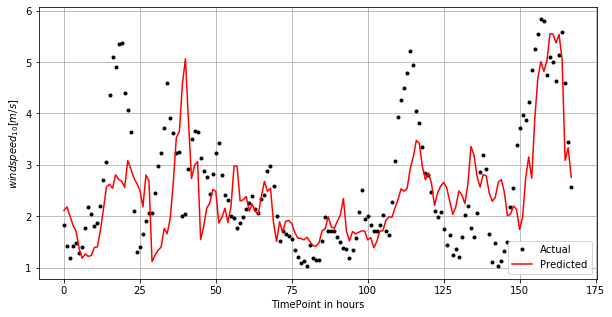

In [13]:
evaluate(dense, Xs_test[4][4], ys_test[4][4])

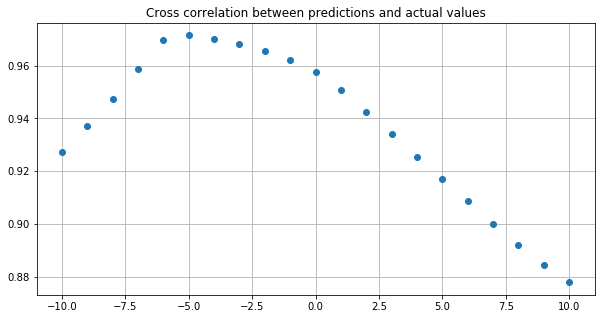

In [14]:
cross_corr(dense, Xs_test[4][4], ys_test[4][4])

## Predykcje dla różnych punktów siatki

In [15]:
rmses = np.zeros([9,9])
for i in range(rmses.shape[0]):
    for j in range(rmses.shape[1]):
        rmses[i,j] = evaluate(dense, Xs_test[i][j], ys_test[i][j], display=False)

In [16]:
rmses

array([[1.2103597 , 1.21779573, 1.19877814, 1.18003251, 1.18395577,
        1.16001601, 1.15113926, 1.12538212, 1.09474957],
       [1.22694444, 1.22666033, 1.19806277, 1.16484865, 1.16030825,
        1.14970165, 1.16765268, 1.17538297, 1.13677269],
       [1.211968  , 1.2249701 , 1.23415062, 1.20329455, 1.21356659,
        1.17580969, 1.18608797, 1.15088819, 1.09598442],
       [1.17956576, 1.19512601, 1.18835461, 1.17844571, 1.19872038,
        1.1504724 , 1.1292338 , 1.10699371, 1.0664164 ],
       [1.11436146, 1.06996779, 1.05941165, 1.05191075, 1.06102759,
        1.01900853, 1.00478645, 1.01281868, 1.02036112],
       [0.96123921, 0.89814073, 0.89267254, 0.89653015, 0.89828391,
        0.86435046, 0.87386989, 0.92879911, 0.97611203],
       [0.86489323, 0.81590438, 0.80578459, 0.78725384, 0.7792795 ,
        0.77776565, 0.79425049, 0.87795526, 0.93321169],
       [0.79235186, 0.75241078, 0.72610966, 0.71853022, 0.71880128,
        0.72407204, 0.78355752, 0.84700338, 0.89511968],


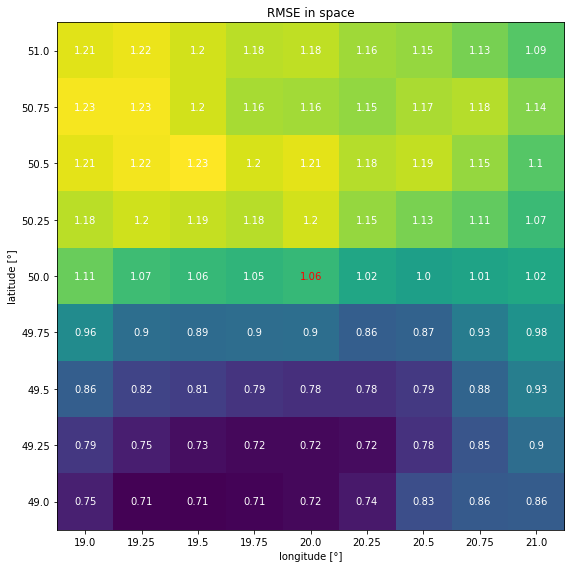

In [17]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.imshow(rmses)
ax.set_xticklabels(np.arange(18.75, 21.25,0.25))
ax.set_yticklabels(np.flip(np.arange(49, 51.5,0.25,)))
ax.set_xlabel("longitude [°]")
ax.set_ylabel("latitude [°]")
ax.set_title("RMSE in space")

for i in range(len(rmses)):
    for j in range(len(rmses[i])):
        if (i,j) == (4,4):
            text = plt.text(j, i, round(rmses[i, j],2),
                            ha="center", va="center", color="r")
        else:
            text = plt.text(j, i, round(rmses[i, j],2),
                            ha="center", va="center", color="w")

fig.tight_layout()

## Odniesienie błędów rmse do odchylenia standardowego:

In [25]:
std_dev = np.ones_like(rmses)

for i in range(9):
    for j in range(9):
        std_dev[i,j] = test_sets[i][j]['windspeed_10'].std()

rmses_norm = rmses/std_dev

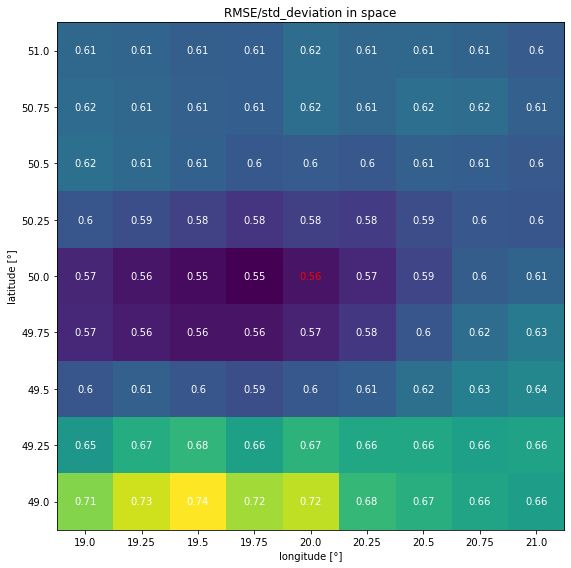

In [30]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.imshow(rmses_norm)
ax.set_xticklabels(np.arange(18.75, 21.25,0.25))
ax.set_yticklabels(np.flip(np.arange(49, 51.5,0.25,)))
ax.set_xlabel("longitude [°]")
ax.set_ylabel("latitude [°]")
ax.set_title("RMSE/std_deviation in space")

for i in range(len(rmses_norm)):
    for j in range(len(rmses_norm[i])):
        if (i,j) == (4,4):
            text = plt.text(j, i, round(rmses_norm[i, j],2),
                            ha="center", va="center", color="r")
        else:
            text = plt.text(j, i, round(rmses_norm[i, j],2),
                            ha="center", va="center", color="w")

fig.tight_layout()

# Analiza wiatru

Przygotowanie danych:

In [232]:
# create set with all history for middle gridpoint
def create_set_raw(to_csv=False):
    data = pd.DataFrame()
    years = range(1950, 2021)
    for year in years:
        filename = 'workdir\\data_raw\\ERA5_single_location\\dane_[50,20]_12m_'+str(year)+'.nc'
        f = netCDF4.Dataset(filename)
        var_names = ['t2m', 'd2m', 'msl', 'tp', 'u10', 'v10', 'u100', 'v100', 'ssrd']
        # latitudes = f.variables['latitude'][:]
        # longitudes = f.variables['longitude'][:]
        times = netCDF4.num2date(f.variables['time'][:], f.variables['time'].units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
        times = [t.isoformat() for t in times]

        variables = {key: f.variables[key][:].flatten() for key in var_names}
        df = pd.DataFrame({**{
            'Date Time': times,
            **variables
        }})
        df['Date Time'] = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)
        df['tp'] = df['tp'].fillna(0)
        ssrd_new = df['ssrd']
        ssrd_new = ssrd_new.where(ssrd_new>10, 0) / 3600 / 1000 #unit from [J/m^2] to [kW/m^2]
        df['ssrd'] = ssrd_new
        # df['windspeed_10'] = (df['u10']**2 + df['v10']**2)**(1/2)
        # df['windspeed_100'] = (df['u100']**2 + df['v100']**2)**(1/2)
        # df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

        data = data.append(df)

    if to_csv:
        data.to_csv('workdir/data_raw/ERA5_single_location/data_raw_[50,20].csv', index = False)

    f.close()
    return data

df = create_set_raw(to_csv=True)

In [233]:
df

,t2m,d2m,msl,tp,u10,v10,u100,v100,ssrd,Date Time
0,262.714033,259.900872,103298.015394,0.000000,0.637819,-2.406421,0.903655,-3.709255,0.0,1950-01-01 00:00:00
1,260.695745,258.184905,103401.866726,0.000000,0.922727,-1.589199,1.500161,-3.410746,0.0,1950-01-01 01:00:00
2,260.195929,257.699157,103434.928307,0.000000,1.599350,-2.048641,1.843544,-3.019235,0.0,1950-01-01 02:00:00
3,259.350219,256.948053,103418.318422,0.000000,1.825593,-1.757785,2.032306,-2.403842,0.0,1950-01-01 03:00:00
4,258.763065,256.665744,103419.030274,0.000000,1.989750,-1.709849,2.543653,-2.705351,0.0,1950-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...
8779,274.643734,274.172750,100974.912154,0.000006,-0.439706,-0.680139,-0.930238,-1.553409,0.0,2020-12-31 19:00:00
8780,274.719036,274.144356,100973.148236,0.000005,-0.410773,-0.765752,-0.861213,-1.216175,0.0,2020-12-31 20:00:00
8781,274.310849,273.971416,100980.668096,0.000003,-0.360798,-0.685017,-0.729079,-1.110241,0.0,2020-12-31 21:00:00
8782,273.450250,273.092257,100972.962561,0.000002,-0.078309,-0.644528,-0.032517,-0.560758,0.0,2020-12-31 22:00:00


Zmiana skladowych u i v na dlugosc i kierunek wektora:

In [234]:
df['windspeed_10'] = (df['u10']**2 + df['v10']**2)**(1/2)
df['windspeed_100'] = (df['u100']**2 + df['v100']**2)**(1/2)
df['wind_dir_10'] = np.mod(180 + 180/np.pi*np.arctan2(df['u10'],df['v10']), 360)
df['wind_dir_100'] = np.mod(180 + 180/np.pi*np.arctan2(df['u100'],df['v100']), 360)

In [216]:
u = 10
v = 5

wd = np.mod(180 + 180/np.pi*np.arctan2(u,v), 360)
print(180/np.pi*np.arctan2(u,v))
print(wd)

63.43494882292201
243.43494882292202


In [217]:
wd = df['wind_dir_10']
ws = df['windspeed_10']

u = -ws*np.sin(wd*np.pi/180)
v = -ws*np.cos(wd*np.pi/180)

print(round(u,3) == round(df['u10'],3))
print(round(v,3) == round(df['v10'],3))

0       True
1       True
2       True
3       True
4       True
        ... 
8779    True
8780    True
8781    True
8782    True
8783    True
Length: 622392, dtype: bool
0       True
1       True
2       True
3       True
4       True
        ... 
8779    True
8780    True
8781    True
8782    True
8783    True
Length: 622392, dtype: bool


In [218]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t2m,622392.0,281.348517,9.054545,2.444595e+02,274.683086,2.815567e+02,288.053868,309.718750
d2m,622392.0,277.549579,7.852594,2.425018e+02,272.109453,2.779259e+02,283.883571,297.707275
msl,622392.0,101637.659869,849.017898,9.699069e+04,101112.471633,1.016280e+05,102154.134430,105211.250000
tp,622392.0,0.000095,0.000300,-8.673617e-19,0.000000,9.132109e-07,0.000049,0.012475
u10,622392.0,0.975534,2.811825,-1.078517e+01,-1.080994,9.705718e-01,2.882221,13.194412
v10,622392.0,0.065453,1.721082,-1.016621e+01,-0.980546,1.754849e-01,1.196467,8.697861
u100,622392.0,1.680956,4.679498,-1.539159e+01,-1.795813,1.626135e+00,5.204679,20.078857
v100,622392.0,0.118806,2.916355,-1.559520e+01,-1.709057,1.391472e-01,1.960504,14.373978
ssrd,622392.0,0.125175,0.192258,0.000000e+00,0.000000,5.321708e-03,0.193523,0.888213
windspeed_10,622392.0,2.974202,1.725847,1.758182e-03,1.714436,2.563923e+00,3.963677,13.795430


Lata 1950 - 2020:

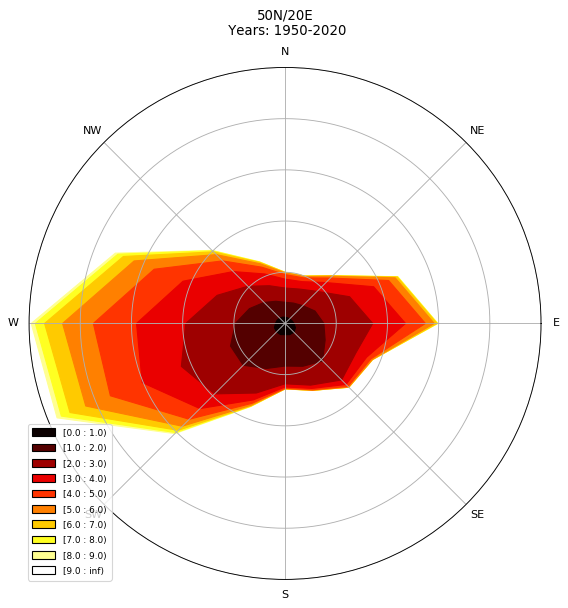

In [219]:
wd = df['wind_dir_10']
ws = df['windspeed_10']

ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 10, 1), cmap=cm.hot)
ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
ax.set_yticklabels([])
ax.set_title("50N/20E\n Years: 1950-2020")
ax.set_legend()

([<matplotlib.axis.XTick at 0x1abfc6f3a60>,
 <a list of 16 Text xticklabel objects>)

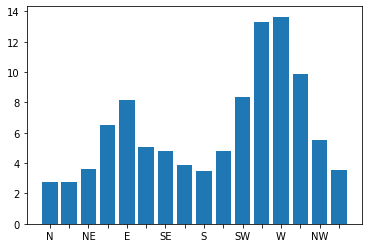

In [220]:
ax.bar(wd, ws, normed=True, nsector=16)
table = ax._info['table']
direction = ax._info['dir']
wd_freq = np.sum(table, axis=0)
plt.bar(np.arange(16), wd_freq, align='center')
xlabels = ['N','','NE','','E','','SE','','S','','SW','','W','','NW','']
xticks=np.arange(16)
plt.xticks(xticks, labels=xlabels)

D:\Programy\Anaconda\envs\tf_gpu\lib\site-packages\windrose\windrose.py:694: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bins = np.histogram(var, bins=bins, normed=True)


Text(0.5, 0, 'Windspeed_10 [m/s]')

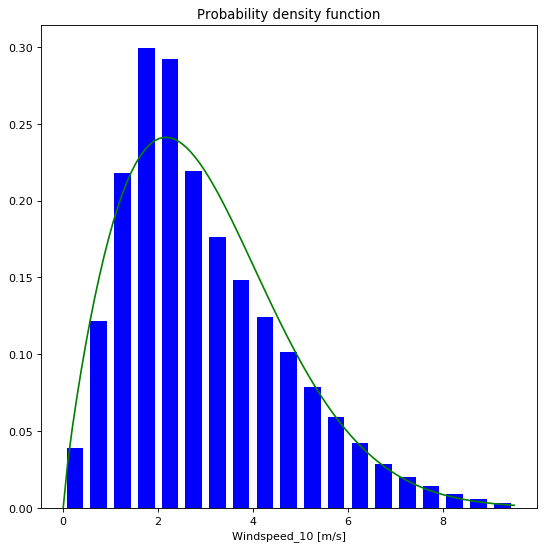

In [221]:
ax = WindAxes.from_ax()
ax, params = ax.pdf(df['windspeed_10'], bins=np.arange(0, 10, 0.5))
ax.set_title("Probability density function")
ax.set_xlabel("Windspeed_10 [m/s]")

Podział na miesiące:

In [247]:
df_all = df.set_index('Date Time')
df_all["by_month"] = df_all.index.map(lambda dt: dt.month)

df_all = df_all.reset_index().set_index(["by_month", "Date Time"])

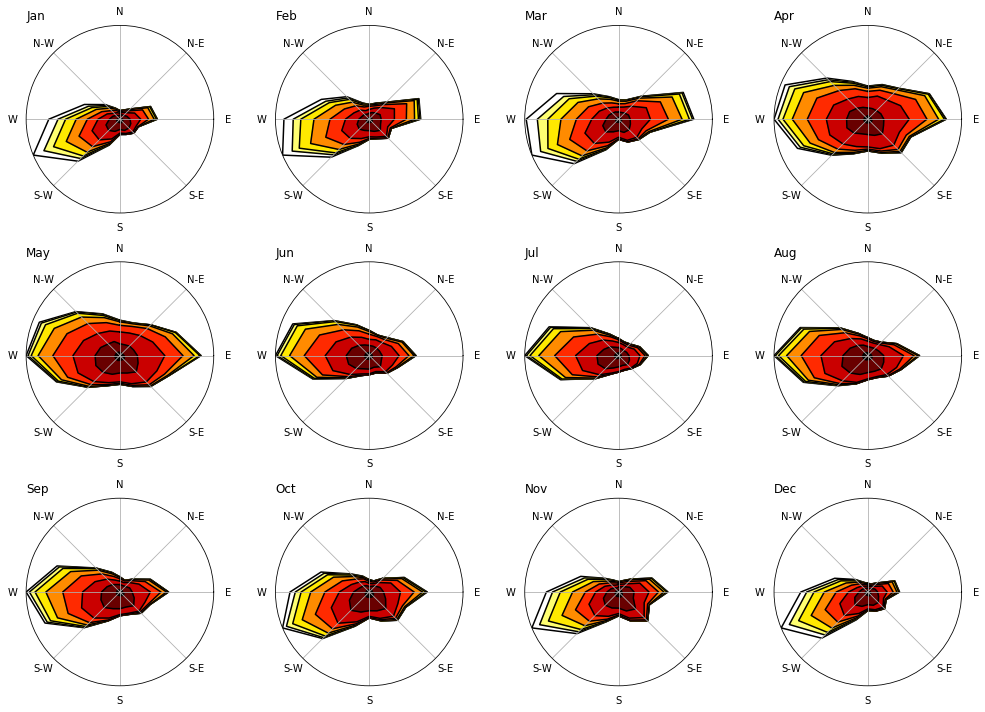

In [250]:
nrows, ncols = 3, 4
fig = plt.figure(figsize=(14,10))
bins = np.arange(0, 8, 1)

for month in range(1, 13):
    ax = fig.add_subplot(nrows, ncols, month, projection="windrose")
    title = datetime.datetime(2002, month, 1).strftime("%b")
    ax.set_title(title, loc='left')
    try:
        df_plot = df_all.loc[month]
    except KeyError:
        continue
    direction = df_plot["wind_dir_10"].values
    var = df_plot["windspeed_10"].values
    ax.contourf(direction, var, bins=bins, cmap=cm.hot)
    ax.contour(direction, var, bins=bins, colors="black")
    ax.set_yticks([])
fig.tight_layout()
plt.show()

Rok 2002 (testowy):

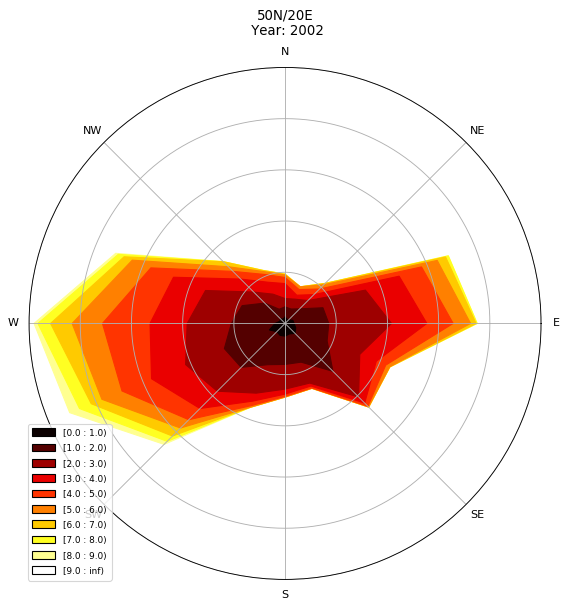

In [238]:
test_year = df[df['Date Time']>='2002-01-01']
test_year = test_year[test_year['Date Time']<'2003-01-01']

ax = WindroseAxes.from_ax()
ax.contourf(test_year['wind_dir_10'], test_year['windspeed_10'], bins=np.arange(0, 10, 1), cmap=cm.hot)
ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
ax.set_yticklabels([])
ax.set_title("50N/20E\n Year: 2002")
ax.set_legend()

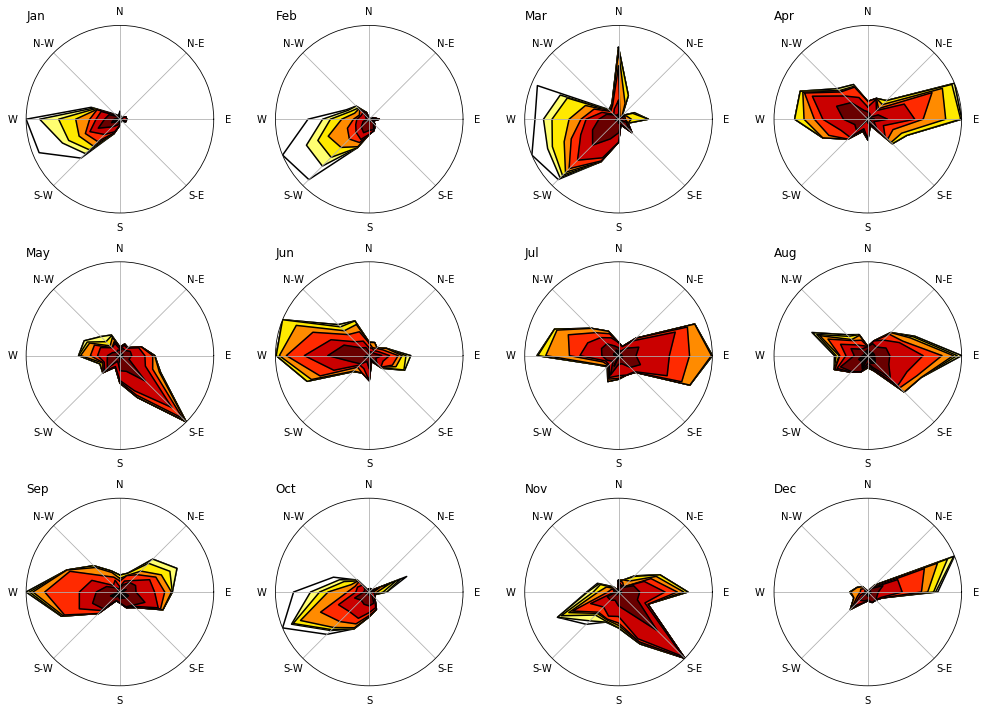

In [251]:
df_all = test_year.set_index('Date Time')
df_all["by_month"] = df_all.index.map(lambda dt: dt.month)

df_all = df_all.reset_index().set_index(["by_month", "Date Time"])

nrows, ncols = 3, 4
fig = plt.figure(figsize=(14,10))
bins = np.arange(0, 8, 1)

for month in range(1, 13):
    ax = fig.add_subplot(nrows, ncols, month, projection="windrose")
    title = datetime.datetime(2002, month, 1).strftime("%b")
    ax.set_title(title, loc='left')
    try:
        df_plot = df_all.loc[month]
    except KeyError:
        continue
    direction = df_plot["wind_dir_10"].values
    var = df_plot["windspeed_10"].values
    ax.contourf(direction, var, bins=bins, cmap=cm.hot)
    ax.contour(direction, var, bins=bins, colors="black")
    ax.set_yticks([])
fig.tight_layout()
plt.show()